In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_cluster import random_walk
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import NeighborSampler as RawNeighborSampler

import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch_geometric.utils import from_smiles, to_networkx

In [22]:
"""table_Cardio = pd.read_csv("cardiovascular_system.csv", sep=",", header= None)
odd_rows = table_Cardio.iloc[1::2]

smiles = odd_rows[0].values.tolist()

def t_smiles(smile): 
    return from_smiles(smile)

Graphs = list(map(t_smiles, smiles))
data = Graphs[0]
print(Graphs[0])
"""


dataset = 'Cora'
path = './data'
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(data.train_mask)

class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)


train_loader = NeighborSampler(data.edge_index, sizes=[10, 10], batch_size=256,
                               shuffle=True, num_nodes=data.num_nodes)


class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)


def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc


for epoch in range(1, 51):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

tensor([ True,  True,  True,  ..., False, False, False])


c:\Users\allan\anaconda3\envs\gnn_project_1\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


Epoch: 001, Loss: 1.3890, Val: 0.3680, Test: 0.3640
Epoch: 002, Loss: 1.3353, Val: 0.4500, Test: 0.4560
Epoch: 003, Loss: 1.1919, Val: 0.5280, Test: 0.5100
Epoch: 004, Loss: 1.1291, Val: 0.6160, Test: 0.5930
Epoch: 005, Loss: 1.0837, Val: 0.6580, Test: 0.6190
Epoch: 006, Loss: 1.0736, Val: 0.6460, Test: 0.6390
Epoch: 007, Loss: 1.0234, Val: 0.6360, Test: 0.6510
Epoch: 008, Loss: 1.0217, Val: 0.6540, Test: 0.6680
Epoch: 009, Loss: 1.0121, Val: 0.6700, Test: 0.6800
Epoch: 010, Loss: 1.0080, Val: 0.6740, Test: 0.6840
Epoch: 011, Loss: 0.9873, Val: 0.6820, Test: 0.6970
Epoch: 012, Loss: 0.9856, Val: 0.7100, Test: 0.7090
Epoch: 013, Loss: 0.9803, Val: 0.7140, Test: 0.7110
Epoch: 014, Loss: 0.9655, Val: 0.7180, Test: 0.7220
Epoch: 015, Loss: 0.9834, Val: 0.7220, Test: 0.7170
Epoch: 016, Loss: 0.9880, Val: 0.7180, Test: 0.7240
Epoch: 017, Loss: 0.9828, Val: 0.7160, Test: 0.7280
Epoch: 018, Loss: 0.9485, Val: 0.7100, Test: 0.7400
Epoch: 019, Loss: 0.9692, Val: 0.7240, Test: 0.7410
Epoch: 020, 

In [23]:
for epoch in range(1, 51):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
    

with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()



Epoch: 001, Loss: 0.9054, Val: 0.7140, Test: 0.7360
Epoch: 002, Loss: 0.9174, Val: 0.7140, Test: 0.7450
Epoch: 003, Loss: 0.9206, Val: 0.7300, Test: 0.7450
Epoch: 004, Loss: 0.9001, Val: 0.7320, Test: 0.7530
Epoch: 005, Loss: 0.9033, Val: 0.7320, Test: 0.7490
Epoch: 006, Loss: 0.9288, Val: 0.7280, Test: 0.7500
Epoch: 007, Loss: 0.8972, Val: 0.7300, Test: 0.7450
Epoch: 008, Loss: 0.9160, Val: 0.7240, Test: 0.7430
Epoch: 009, Loss: 0.9175, Val: 0.7100, Test: 0.7310
Epoch: 010, Loss: 0.9006, Val: 0.7120, Test: 0.7420
Epoch: 011, Loss: 0.9193, Val: 0.7160, Test: 0.7510
Epoch: 012, Loss: 0.9029, Val: 0.7200, Test: 0.7410
Epoch: 013, Loss: 0.8921, Val: 0.7140, Test: 0.7310
Epoch: 014, Loss: 0.9110, Val: 0.7120, Test: 0.7370
Epoch: 015, Loss: 0.8885, Val: 0.7120, Test: 0.7340
Epoch: 016, Loss: 0.9060, Val: 0.7140, Test: 0.7350
Epoch: 017, Loss: 0.9147, Val: 0.7200, Test: 0.7440
Epoch: 018, Loss: 0.9054, Val: 0.7160, Test: 0.7390
Epoch: 019, Loss: 0.9038, Val: 0.7200, Test: 0.7370
Epoch: 020, 

In [24]:
palette = {}

for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

In [25]:
embd = umap.UMAP().fit_transform(out.cpu().numpy())

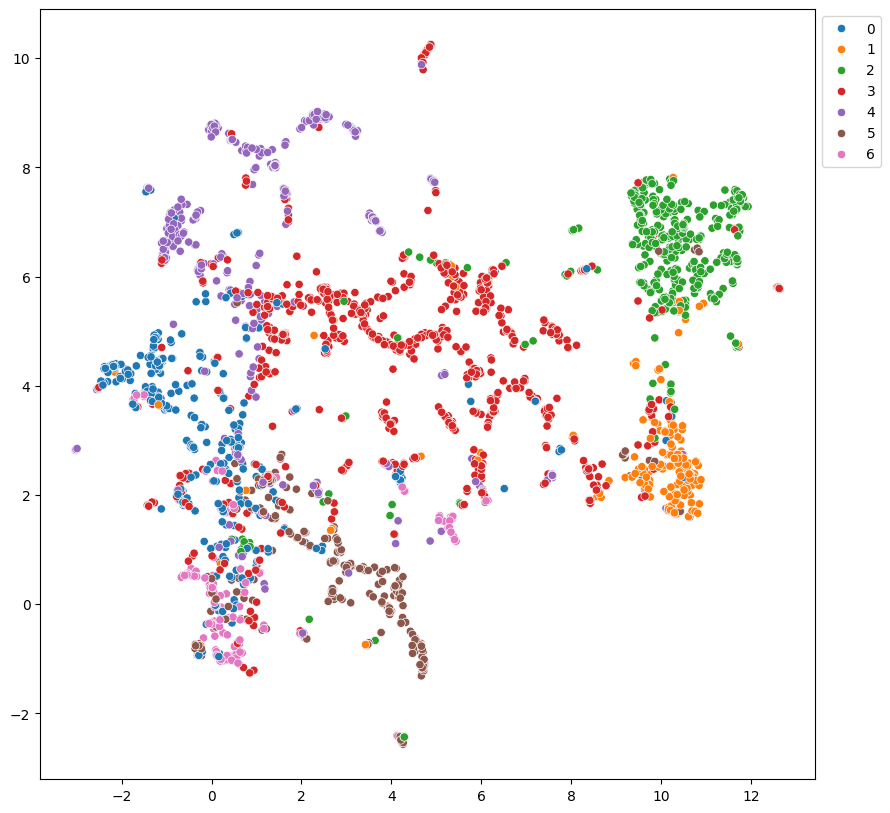

In [26]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd_sage.png", dpi=120)